In [1]:

import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import weightedstats as ws


## Functions and tools used in the analysis

In [2]:
def weighted_mean(var, wts):
    """Calculates the weighted mean"""
    return np.average(var, weights=wts)

def weighted_median_series(val, weight):
    """Calculates the weighted median
    ArithmeticError
    If the sum of the weights is zero, or if the weights are not positive.
    """
    try:
        df = pd.DataFrame({"val": val, "weight": weight})
        df_sorted = df.sort_values("val")
        cumsum = df_sorted["weight"].cumsum()
        cutoff = df_sorted["weight"].sum() / 2.
        result = df_sorted[cumsum >= cutoff]["val"].iloc[0]
        # return just the value
    except:
        result = np.nan
    return result

def weighted_median(df, val_column, weight_column):
    """Calculates the weighted median
    ArithmeticError
    If the sum of the weights is zero, or if the weights are not positive.
    """
    df_sorted = df.sort_values(val_column)
    cumsum = df_sorted[weight_column].cumsum()
    cutoff = df_sorted[weight_column].sum() / 2.
    return df_sorted[cumsum >= cutoff][val_column].iloc[0]

def run_weighted_median_on_grouped_df(df, groupby_column, value_column, weight_column):
    """Calculate the weighted median of a dataframe grouped by a column.
    Args:
        df (pandas.DataFrame): DataFrame to calculate weighted median on.
        groupby_column (str): Column to group by.
        value_column (str): Column to calculate weighted median on.
        weight_column (str): Column to use as weight.
    Returns:
        pandas.DataFrame: DataFrame with weighted median for each group.
    """
    # initialize empty list
    d = []
    # loop through each group
    for i in df[groupby_column].unique():
        df_group = df[df[groupby_column] == i]
        # if rows in dataframe are more than 1, calculate weighted median
        if len(df_group) > 1:
            median = weighted_median(df_group, value_column, weight_column)
        else:
            median = df_group[value_column].values[0]
        d.append(
            {
                groupby_column: i,
                "median": median,
            }
        )
    return pd.DataFrame(d)


def load_data(data_file: str) -> pd.DataFrame:
    '''
    Load data from /data directory
    '''
    PATH = pathlib.Path().resolve()
    DATA_PATH = PATH.joinpath("../data").resolve()
    return pd.read_csv(DATA_PATH.joinpath(data_file))



## Import Data from CSVs.
CSVs created in previous script, which did the cycling mobility on a per country basis

### GIS Data From QGIS Export
https://ghsl.jrc.ec.europa.eu/download.php?ds=smod <- urbanisation

https://www.earthenv.org/topography <- topography

https://www.globio.info/download-grip-dataset <- roads


In [3]:

# Load the data
# urb_data_file = "../data/GIS/GIS_data_zones.csv"
urb_data_file = "../data/GIS/gis_data_districts_export_1.csv"
country_data_file = "../data/processed/country_data_master_interpolated.csv"
export_file_location = "../data/processed/"

# df_zones_input = pd.read_csv(urb_data_file, low_memory=False)
df_zones_input = pd.read_csv(
    urb_data_file,
    low_memory=False,
    dtype={
        "id": "Int64", 
        "left": float, 
        "top": float, 
        "right": float, 
        "bottom": float, 
        "row_index": "Int64",
        "col_index": "Int64",
        "COUNTRY": object, 
        "ISO": object, 
        "COUNTRYAFF": object, 
        "AFF_ISO": object,
        "shapeName": object, 
        "shapeID": object, 
        "shapeGroup": object, 
        "shapeType": object,
        "dtw_1": float,
        "URBAN_1": "Int64",
        "pop_count_15": float,
        "slope_1": float,
        "grip_1_1": float,
        "grip_1_2": float,
        "grip_1_3": float,
        "grip_1_4": float,
        "grip_1_5": float,
        }
    )
df_input = pd.read_csv(country_data_file)

# Data manipulation
# Convert dtw_1 from meters to kilometers
df_zones_input["dtw_1"] /= 1000 


# Option to calculate the distance, 1 = runs numerical calculation - takes about 15 mins on my macbook pro, 0 = uses csvs from previous run
# only set to 1 if you'd like to recalculate the distance based on new parameters (changed load, changed Crrs etc)
calculate_distance = 1


: 

# Manage Urban / Rural Data
Use the GHS_SMOD_E2020_GLOBE_R2023A_54009_1000_V1_0 dataset.
from here: https://ghsl.jrc.ec.europa.eu/download.php?ds=smod

In [4]:

# create new binary column for urban / rural. Rural is below 15, Urban above 15
df_zones_input["urban_rural"] = np.where(df_zones_input["URBAN_1"] > 15, 1, 0)
df_zones_input["urban_rural"].value_counts()


0    2220541
1      42618
Name: urban_rural, dtype: int64

# Manage slope.

Degrees from earthenv dataset

0.00     0.000000
0.05     0.097832
0.10     0.138355
0.15     0.218758
0.20     0.280146
0.25     0.360782
0.30     0.450444
0.35     0.548193
0.40     0.656249
0.45     0.787484
0.50     0.935736
0.55     1.121305
0.60     1.358873
0.65     1.667845
0.70     2.111629
0.75     2.770306
0.80     3.795188
0.85     5.369263
0.90     7.810654
0.95    11.961503
Name: slope_1, dtype: float64

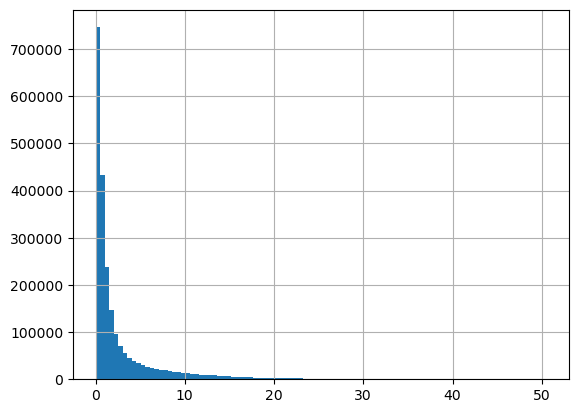

In [5]:
# histogram of slope_1 log scale
df_zones_input["slope_1"].hist(bins=100, log=False)

# qunaitles of slope_1, do 20 quantiles
df_zones_input["slope_1"].quantile(np.arange(0, 1, 0.05))


# Manage Roads



## Merge the dataframes
Do some manual adjustments to populations

In [6]:

# this analysis loses some data as the overlap between the rasters is not perfect. To reduce this error, use the 30 arc second data. Too much heavy lifting for my computer to do this at the moment.

#merge df_input and df_zones on ISO_CC. This assigns all the country data to each zone.
# join inner will remove some of the data that is not in both datasets
df_zones = df_zones_input.merge(df_input, left_on="ISOCODE", right_on="alpha3", how="inner")

# these are the columns
# alpha3,Unnamed: 0,Entity,Population,YearPBO,PBO,Terrain Ruggedness,Urban %,Urban Agg %,RoadQuality,Km,Urb %,Average household size (number of members),National At Least Basic,National Limit (more than 30 mins),National Unimproved,National Surface Water,Nat Accesible On Premises,Nat Piped,Nat NonPiped,No. HPs,Year of HP estimate,2015 (C),No. HPs in 2015,Non-functional HPs,Functional HPS,Risk Score,alpha2,region,subregion,borders,Mean BMI (male),Mean BMI (female),Mean male height (cm),Mean female height (cm),women weight,men weight,percent_insufficient_activity,Average Weight,power,Crr,trip_velocity_mean,unloaded_velocity_mean,loaded_velocity_mean,velocitykgs,water_ration_kms

#adjust population to account for 9 values per raster point (2.5 to 5 arc min resoltuions. 9 values per point)
df_zones["AdjPopFloat"] = df_zones["pop_count_15_1"] / 9 

# # convert population density to percent of national population on a per country basis, grouped by ISO_CC
df_zones["pop_density_perc"] = df_zones.groupby("ISOCODE")["AdjPopFloat"].apply(lambda x: x / x.sum())

# multiply population density by population on a per country basis
df_zones["pop_zone"] = df_zones["pop_density_perc"] * df_zones["Population"]



In [7]:
# sum the population in each zone
df_zones["country_pop_raw"] = df_zones.groupby("ISOCODE")["pop_zone"].transform("sum")
df_zones["country_pop_ratio"] = df_zones.groupby("ISOCODE")["AdjPopFloat"].transform("sum")


In [8]:
# trim the dataframe to only include rows where there is a population
# find non zero values AdjPopFloat
df_zones["any_pop"] = df_zones["AdjPopFloat"].apply(
    lambda x: 1 if x > 10 else 0
)
df_zones = df_zones[df_zones["any_pop"] == 1]


## Do Road Analysis from GRIP Data

<AxesSubplot:>

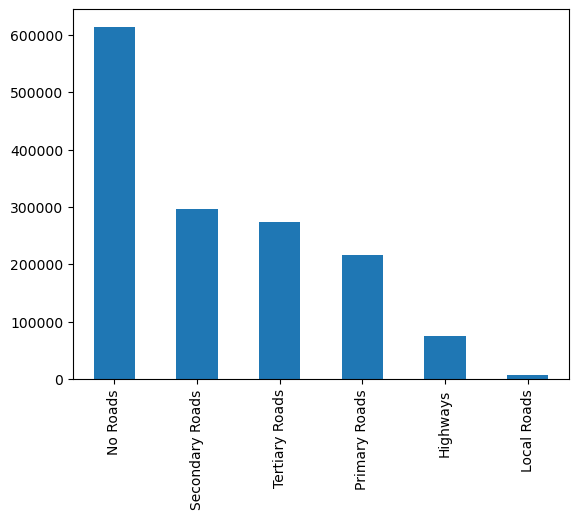

In [9]:
# Define the columns to work with
columns = ["grip_1_1", "grip_2_1", "grip_3_1", "grip_4_1", "grip_5_1"]

# Create a numpy array from the DataFrame for faster processing
data = df_zones[columns].to_numpy()

# Find the index of the first non-zero value in each row
non_zero_indices = np.argmax(data != 0, axis=1)

# Handle rows with all zeros
all_zeros = np.all(data == 0, axis=1)
non_zero_indices[all_zeros] = -1  # Set a distinct value for rows with all zeros

# Map indices to road types
road_types = np.array(['No Roads', 'Highways', 'Primary Roads', 'Secondary Roads', 'Tertiary Roads', 'Local Roads'])

# Assign the dominant road type
df_zones['dominant_road_type'] = road_types[non_zero_indices + 1]  # +1 to adjust for 'No Roads'

# Histogram of dominant road type
df_zones['dominant_road_type'].value_counts().plot(kind='bar')


In [10]:
# Load the CSV file
df_crr = pd.read_csv("../data/lookup tables/Crr.csv")

# Create a dictionary from the DataFrame
crr_mapping = pd.Series(df_crr.Crr.values, index=df_crr['Assigned Zone Surface']).to_dict()

# Map the road types in df_zones to Crr values
df_zones['Crr'] = df_zones['dominant_road_type'].map(crr_mapping)

# Now df_zones will have an additional column 'Crr' containing the corresponding Crr values


## The section below calculates the population per zone that can reach water

Consider putting in household size and bike sharing here

In [11]:
load_attempt = 25 # kg

calculate_distance = True
if calculate_distance:
    # Calculate the bicycle distance
    import sys
    from pathlib import Path

    # Resolve project root and update sys.path
    project_root = Path().resolve().parent
    sys.path.append(str(project_root))
    
    import src.mobility_module as mm

    # Import data
    file_path_params = "../data/lookup tables/mobility-model-parameters.csv"
    allHPV_param_df = pd.read_csv(file_path_params)
    param_df = allHPV_param_df[allHPV_param_df["Name"] == "Bicycle"]

    # Initialize model options and variables
    mo = mm.model_options()
    mo.model_selection = 2  # Cycling model

    mv = mm.model_variables()
    #TODO update to use country weights?
    met = mm.MET_values(mv, country_weight=False, use_country_specific_weights=False)
    hpv = mm.HPV_variables(param_df, mv)

    # Ensure that the 'Crr' column is in the correct format (e.g., float)
    df_zones['Crr'] = df_zones['Crr'].astype(float)

    # Extract slope and Crr values
    slope_zones = df_zones["slope_1"]
    Crr_values = df_zones["Crr"]
    country_average_weights = df_zones["Average Weight"]

    # Model run setup
    n_runs = len(slope_zones)

    # Initialize result vectors
    results = np.zeros((n_runs, 3))

    # Run model with both slope and Crr
    for i, (slope, crr, country_average_weight) in enumerate(zip(slope_zones, Crr_values, country_average_weights)):
        hpv.Crr = crr
        mv.m1 = country_average_weight
        results[i] = mm.mobility_models.single_bike_run(mv, mo, hpv, slope, load_attempt) 
    # Unpack results
    loaded_velocity_vec, unloaded_velocity_vec, max_load_vec = results.T

    # average velocity between loaded and unloaded
    average_velocity = (loaded_velocity_vec + unloaded_velocity_vec) / 2

    # save the results csv
    df_zones["loaded_velocity_bicycle"] = loaded_velocity_vec
    df_zones["unloaded_velocity_bicycle"] = unloaded_velocity_vec
    df_zones["average_velocity_bicycle"] = average_velocity
    df_zones["max_load_bicycle"] = max_load_vec

    #only save the newly created cols in the csv
    df_zones[["fid", "loaded_velocity_bicycle", "unloaded_velocity_bicycle", "average_velocity_bicycle", "max_load_bicycle"]].to_csv(export_file_location + "bicycle_velocity_by_zone.csv")

else:
    # load the results csv
    df_zones_bicycle = pd.read_csv(export_file_location + "bicycle_velocity_by_zone.csv")

    # merge the results with the main df
    df_zones = df_zones.merge(df_zones_bicycle, on="fid", how="left")



In [12]:
load_attempt = 20 # kg

if calculate_distance:
    # Calculate the walking distance
    import sys
    from pathlib import Path


    # Resolve project root and update sys.path
    project_root = Path().resolve().parent
    sys.path.append(str(project_root))
    
    import src.mobility_module as mm

    # Import data
    file_path_params = "../data/lookup tables/mobility-model-parameters.csv"
    allHPV_param_df = pd.read_csv(file_path_params)
    param_df = allHPV_param_df[allHPV_param_df["Name"] == "Buckets"]

    # Initialize model options and variables
    mo = mm.model_options()
    mo.model_selection = 3  # Lankford model

    mv = mm.model_variables()
    #TODO update to use country weights?
    # met = mm.MET_values(mv, country_weight=False, use_country_specific_weights=False)
    hpv = mm.HPV_variables(param_df, mv)

    # Ensure that the 'Crr' column is in the correct format (e.g., float)
    df_zones['Crr'] = df_zones['Crr'].astype(float)

    # Extract slope and Crr values
    slope_zones = df_zones["slope_1"]
    Crr_values = df_zones["Crr"]
    country_average_weight = df_zones["Average Weight"]

    # Model run setup
    n_runs = len(slope_zones)

    # Initialize result vectors
    results = np.zeros((n_runs, 3))

    # Run model with both slope and Crr
    for i, (slope, country_average_weight) in enumerate(zip(slope_zones, country_average_weights)):
        mv.m1 = country_average_weight
        met_values = mm.MET_values(mv, country_weight=country_average_weight, use_country_specific_weights=True)
        results[i] = mm.mobility_models.single_lankford_run(
            mv, mo, met_values, hpv, slope, load_attempt
        )
    # Unpack results
    loaded_velocity_vec, unloaded_velocity_vec, max_load_vec = results.T

    # average velocity between loaded and unloaded
    average_velocity = (loaded_velocity_vec + unloaded_velocity_vec) / 2

    # save the results csv
    df_zones["loaded_velocity_walk"] = loaded_velocity_vec
    df_zones["unloaded_velocity_walk"] = unloaded_velocity_vec
    df_zones["average_velocity_walk"] = average_velocity
    df_zones["max_load_walk"] = max_load_vec

    #only save the newly created cols in the csv
    df_zones[["fid", "loaded_velocity_walk", "unloaded_velocity_walk", "average_velocity_walk", "max_load_walk"]].to_csv(export_file_location + "walk_velocity_by_zone.csv")

else:
    # load the results csv
    df_zones_walking = pd.read_csv(export_file_location + "walk_velocity_by_zone.csv")

    # merge the results with the main df
    df_zones = df_zones.merge(df_zones_walking, on="fid", how="left")



In [13]:
time_gathering_water = 7
df_zones["max distance cycling"] = df_zones["average_velocity_bicycle"] * time_gathering_water / 2 # max distance achievable (not round trip, just the distance from home to water source)
df_zones["max distance walking"] = df_zones["average_velocity_walk"] * time_gathering_water / 2
df_zones["water_ration_kms"] = df_zones["max distance cycling"] * df_zones["max_load_bicycle"]

In [14]:
# # population with piped water

# set df_zones["zone_pop_piped"] to 0 for all zones to begin with
df_zones["zone_pop_piped"] = 0

# if urban use urban piped and unpiped, if rural use rural piped and unpiped
# use the urban_rural column to do this (where urban_rural = 1, use urban, where urban_rural = 0, use rural)
df_zones["zone_pop_piped"] = df_zones["pop_zone"] * df_zones["urban_rural"] * df_zones["URBANPiped"]/100 + df_zones["pop_zone"] * (1-df_zones["urban_rural"]) * df_zones["RURALPiped"]/100
df_zones["zone_pop_unpiped"] = df_zones["pop_zone"] * df_zones["urban_rural"] * df_zones["URBANNon-piped"]/100 + df_zones["pop_zone"] * (1-df_zones["urban_rural"]) * df_zones["RURALNon-piped"]/100

# is it possible to reach water with walking/cycling
df_zones["zone_cycling_okay"] = (df_zones["dtw_1"] < df_zones["max distance cycling"])*1 # multiply by 1 to force to binary not true/false
df_zones["zone_walking_okay"] = (df_zones["dtw_1"] < df_zones["max distance walking"])*1

# how many people can collect water in the zone
df_zones["fraction_of_zone_with_cycling_access"] = df_zones["zone_cycling_okay"]* (df_zones["PBO"])/100
df_zones["fraction_of_zone_with_walking_access"] = df_zones["zone_walking_okay"] * 1

#
df_zones["population_piped_with_cycling_access"] = df_zones["fraction_of_zone_with_cycling_access"] * df_zones["zone_pop_piped"]
df_zones["population_piped_with_walking_access"] = df_zones["fraction_of_zone_with_walking_access"] * df_zones["zone_pop_piped"]

# select the maximum between the two, if walkable, max will always be walking
df_zones["population_piped_with_access"] = df_zones[["population_piped_with_cycling_access", "population_piped_with_walking_access"]].max(axis=1)

# zone pop without water
df_zones["zone_pop_with_water"] =  df_zones["population_piped_with_access"] + df_zones["zone_pop_unpiped"]
df_zones["zone_pop_without_water"] = df_zones["pop_zone"] - df_zones["zone_pop_with_water"]

# use water_ration_kms to calculate the water ration achievable per bike per zone
df_zones["water_rations_per_bike"] = df_zones["water_ration_kms"] / df_zones["dtw_1"]

# number oif bikes per zone is population divided by household nuymber multipled by PBO
df_zones["bikes_in_zone"] = df_zones["pop_zone"] / df_zones["Average household size (number of members)"] * df_zones["PBO"]

#water rations achievable utilising all the bikes in the zone is the number of bikes in the zone multiplied by the water rations per bike
df_zones["water_rations_achievable"] = df_zones["bikes_in_zone"] * df_zones["water_rations_per_bike"]



In [15]:
df_zones["zone_pop_unpiped"].describe()

count    1.481674e+06
mean     1.646975e+03
std      8.653241e+03
min      0.000000e+00
25%      6.560864e+00
50%      4.893252e+01
75%      5.727339e+02
max      1.127543e+06
Name: zone_pop_unpiped, dtype: float64

In [16]:
# Export df_zones to "results" folder
df_zones.to_csv("../results/df_zones_export.csv", index=False)


In [23]:
# count rows of df_zones
df_zones.shape
# display column names without truncation
# pd.options.display.max_columns = None
# df_zones.head()

(1481674, 120)

## Temporary INPUT ZONE

In [3]:
### TEMPORARY INPUT ZONE ###
# TODO Delete this cell
df_zones = pd.read_csv(
    "../data/GIS/districts_data.csv", 
    # dtype={
    #     "id": int, 
    #     "left": float, 
    #     "top": float, 
    #     "right": float, 
    #     "bottom": float, 
    #     "COUNTRY": object, 
    #     "ISO": object, 
    #     "COUNTRYAFF": object, 
    #     "AFF_ISO": object, 
    #     "DTW_1": float, 
    #     "shapeName": object, 
    #     "shapeID": object, 
    #     "shapeGroup": object, 
    #     "shapeType": object
    #     }
    )
# sum the population in each zone
df_zones["district_pop_raw"] = df_zones.groupby("shapeID")["pop_zone"].transform("sum")

/tmp/ipykernel_203062/317138879.py:3: DtypeWarning: Columns (85,120,121,122,123) have mixed types. Specify dtype option on import or set low_memory=False.
  df_zones = pd.read_csv(


In [5]:
df_zones_copy = df_zones.copy()

In [6]:
# Group into subnational
# use groupby to create dataframe of country level data from df_zones
df_zones = df_zones_copy.copy()
df_districts = df_zones.groupby("shapeID").agg({
    "Entity": "first",
    "ISOCODE": "first",
    "shapeName": "first",
    "district_pop_raw": "first",
    "zone_pop_with_water": "sum",
    "zone_pop_without_water": "sum",
    "population_piped_with_access": "sum",
    "population_piped_with_cycling_access": "sum",
    "population_piped_with_walking_access": "sum",
    "Nat Piped": "first",
    "region": "first",
    "subregion": "first",
    "max distance cycling": ["mean", "max", "min", "median"],
    "max distance walking": ["mean", "max", "min", "median"],
}).reset_index()

# Rename the columns
df_districts.columns = [
    "shapeID",
    "Entity", 
    "ISOCODE",
    "shapeName",
    "district_pop_raw", 
    "zone_pop_with_water", 
    "zone_pop_without_water",
    "population_piped_with_access", 
    "population_piped_with_cycling_access",
    "population_piped_with_walking_access", 
    "Nat Piped", 
    "region", 
    "subregion",
    "mean_max_distance_cycling", 
    "max_max_distance_cycling", 
    "min_max_distance_cycling",
    "median_max_distance_cycling", 
    "mean_max_distance_walking", 
    "max_max_distance_walking",
    "min_max_distance_walking", 
    "median_max_distance_walking",
    ]
# df_districts = df_districts.rename(
#     columns={
#         "shapeID": "shapeID",
#         "(shapeID, )": "shapeID_2",
#         "(Entity, first)": "Entity",
#         "('shapeName', 'first')": "shapeName",
#         "('district_pop_raw', 'first')": "district_pop_raw",
#         "('zone_pop_with_water', 'sum')": "zone_pop_with_water",
#         "('zone_pop_without_water', 'sum')": "zone_pop_without_water",
#         "('population_piped_with_access', 'sum')": "population_piped_with_access",
#         "('population_piped_with_cycling_access', 'sum')": "population_piped_with_cycling_access",
#         "('population_piped_with_walking_access', 'sum')": "population_piped_with_walking_access",
#         "('Nat Piped', 'first')": "Nat Piped",
#         "('region', 'first')": "region",
#         "('subregion', 'first')": "subregion",
#         "('max distance cycling', 'mean')": "mean_max_distance_cycling",
#         "('max distance cycling', 'max')": "max_max_distance_cycling",
#         "('max distance cycling', 'min')": "min_max_distance_cycling",
#         "('max distance cycling', 'median')": "median_max_distance_cycling",
#         "('max distance walking', 'mean')": "mean_max_distance_walking",
#         "('max distance walking', 'max')": "max_max_distance_walking",
#         "('max distance walking', 'min')": "min_max_distance_walking",
#         "('max distance walking', 'median')": "median_max_distance_walking",
#         }
#     )



# use groupby to create weighted median, needs to be speerate from the above groupby as it uses apply, which can't be used in the same groupby
# needs to use apply because the function required two columns as input
df_median_group = df_zones.groupby(['shapeID']).apply(lambda x : pd.Series({'weighted_med':weighted_median(x,"dtw_1","pop_zone")}))

# merge the weighted median back into the df_districts dataframe
df_districts = df_districts.merge(df_median_group, on="shapeID")

# drop rows from the dataframe that have Nan in pop_zone and dtw_1
df_zones = df_zones.dropna(subset=["pop_zone", "dtw_1"])

# create summary columns
#rename zone columns to country
print(df_districts.head())
df_districts = df_districts.rename(columns={"zone_pop_with_water":"district_pop_with_water", "zone_pop_without_water":"district_pop_without_water"})

# create percent
df_districts["percent_with_water"] = df_districts["district_pop_with_water"] / df_districts["district_pop_raw"] * 100
df_districts["percent_without_water"] = df_districts["district_pop_without_water"] / df_districts["district_pop_raw"] * 100

                   shapeID   Entity ISOCODE    shapeName  district_pop_raw  \
0   10019604B1094996199402  Albania     ALB        Berat      85910.550399   
1  10019604B11091570243697  Albania     ALB        Korçë     209696.943156   
2  10019604B18588012879070  Albania     ALB         Fier     255123.773407   
3  10019604B29738820438867  Albania     ALB  Gjirokastër      60000.709369   
4  10019604B30424798991477  Albania     ALB       Tiranë     949106.815656   

   zone_pop_with_water  zone_pop_without_water  population_piped_with_access  \
0         71818.034372            14092.516027                  54243.182114   
1        165873.188667            43823.754489                 122695.470761   
2        220653.434185            34470.339222                 168706.194104   
3         49418.882358            10581.827011                  36818.733391   
4        913884.381949            35222.433708                 730142.661383   

   population_piped_with_cycling_access  populatio

In [7]:
# Clean up data from spurious country values
# uses libya as the max possible diatnce to water (from Kummu paper results)

# remove any nan rows
df_districts = df_districts.dropna()


# first pass clean up

# remove any rows where the median is more than 1km more than "LBY" (Libya)'s median these are clerly errors as no-country can be further than Libya (based on inspection of Kummu Results)
# max_distance = df_districts.loc[df_districts["ISOCODE"] == "LBY", "weighted_med"].values[0] + 1
# countries_further_than_libya = df_countries[df_countries["weighted_med"] > max_distance]
# df_countries = df_countries[df_countries["weighted_med"] < max_distance]

####### Manual remove countries ###############
# inspecting the results, there are a few countries that are clearly wrong, remove them manually
list_of_countries_to_remove = ["GUM", "ASM", "TON", "MNP", "ATG", "DMA", "ABW", "BRB"]
df_of_countries_to_remove = df_districts[df_districts["ISOCODE"].isin(list_of_countries_to_remove)]
df_districts = df_districts[~df_districts["ISOCODE"].isin(list_of_countries_to_remove)]
##############################


# summary of removed countries
# print("Countries removed from analysis")
# print(countries_further_than_libya[["Entity", "weighted_med"]])
print("Countries removed manually")
print(df_of_countries_to_remove[["Entity", "weighted_med"]])






Countries removed manually
                        Entity  weighted_med
133                      Tonga      1.000000
134                      Tonga      1.000000
135                      Tonga    119.100797
136                      Tonga    149.883297
429                   Barbados    154.350297
430                   Barbados    136.341500
431                   Barbados    140.911297
432                   Barbados    147.566906
433                   Barbados    144.138797
434                   Barbados    133.270406
2213  Northern Mariana Islands    193.752406
2233                      Guam     14.212670
2240            American Samoa    109.110000
2525       Antigua and Barbuda     50.209559
2526       Antigua and Barbuda     63.245551
2528       Antigua and Barbuda    105.948102
2529       Antigua and Barbuda     64.350602
2530       Antigua and Barbuda     56.080301
2911                  Dominica     52.000000
2912                  Dominica     69.260383
2913                  Domini

In [8]:
GEOJSON_PATH = "../data/GIS/geoBoundariesCGAZ_ADM1.geojson"
import geojson as gj
with open(GEOJSON_PATH) as f:
    geojson = gj.load(f)

In [10]:
# create choropleth map of population with water from df_country

hover_data_list =[
    "Entity",
    "shapeName",
    "district_pop_raw",
    "district_pop_with_water",
    "district_pop_without_water",
    "population_piped_with_access",
    "population_piped_with_cycling_access",
    "population_piped_with_walking_access",
    "percent_without_water",
    "percent_with_water",
    "Nat Piped",
    "region",
    "subregion",
    "weighted_med",
    "mean_max_distance_cycling", 
    "max_max_distance_cycling", 
    "min_max_distance_cycling",
    "median_max_distance_cycling", 
    "mean_max_distance_walking", 
    "max_max_distance_walking",
    "min_max_distance_walking", 
    "median_max_distance_walking",
    ]


# fig = px.choropleth(df, geojson=counties, locations='fips', color='unemp',
#                            color_continuous_scale="Viridis",
#                            range_color=(0, 12),
#                            scope="usa",
#                            labels={'unemp':'unemployment rate'}
#                           )

# fig = px.choropleth(df, geojson=geojson, color="Bergeron",
#                     locations="district", featureidkey="properties.district",
#                     projection="mercator"
#                    )

choro = px.choropleth(
    data_frame=df_districts[df_districts["ISOCODE"] == "VEN"],
    geojson=geojson,
    locations="shapeID",
    featureidkey="shapeID",
    title="Percent of Population Has to Relocate",
    height=600,
    color="percent_without_water",
    # use constant colorbar grading (not relative)
    color_continuous_scale="ylorbr",
    range_color=(0, 100),
    scope="world",
    hover_name="shapeName",
    hover_data=hover_data_list
)
choro.layout.coloraxis.colorbar.title = ''
choro.update_geos(fitbounds="locations")
choro.show()



: 

## Group the zones in to country groups
Use groupby agg and then apply to summarise the zone data in to country level, then create some summary columns

In [19]:
# use groupby to create dataframe of country level data from df_zones
df_countries = df_zones.groupby("ISOCODE").agg({
    "Entity": "first",
    "country_pop_raw": "first",
    "zone_pop_with_water": "sum",
    "zone_pop_without_water": "sum",
    "population_piped_with_access": "sum",
    "population_piped_with_cycling_access": "sum",
    "population_piped_with_walking_access": "sum",
    "Nat Piped": "first",
    "region": "first",
    "subregion": "first",
    "max distance cycling": ["mean", "max", "min", "median"],
    "max distance walking": ["mean", "max", "min", "median"],
}).reset_index()

# Rename the columns
df_countries.columns = ["ISOCODE", "Entity", "country_pop_raw", "zone_pop_with_water", "zone_pop_without_water",
                        "population_piped_with_access", "population_piped_with_cycling_access",
                        "population_piped_with_walking_access", "Nat Piped", "region", "subregion",
                        "mean_max_distance_cycling", "max_max_distance_cycling", "min_max_distance_cycling",
                        "median_max_distance_cycling", "mean_max_distance_walking", "max_max_distance_walking",
                        "min_max_distance_walking", "median_max_distance_walking"]

# use groupby to create weighted median, needs to be speerate from the above groupby as it uses apply, which can't be used in the same groupby
# needs to use apply because the function required two columns as input
df_median_group = df_zones.groupby(['ISOCODE']).apply(lambda x : pd.Series({'weighted_med':weighted_median(x,"dtw_1","pop_zone")}))

# merge the weighted median back into the df_countries dataframe
df_countries = df_countries.merge(df_median_group, on="ISOCODE")

# drop rows from the dataframe that have Nan in pop_zone and dtw_1
df_zones = df_zones.dropna(subset=["pop_zone", "dtw_1"])

# create summary columns
#rename zone columns to country
df_countries = df_countries.rename(columns={"zone_pop_with_water":"country_pop_with_water", "zone_pop_without_water":"country_pop_without_water"})
# create percent
df_countries["percent_with_water"] = df_countries["country_pop_with_water"] / df_countries["country_pop_raw"] * 100
df_countries["percent_without_water"] = df_countries["country_pop_without_water"] / df_countries["country_pop_raw"] * 100

Clean Up Data

In [20]:
# Clean up data from spurious country values
# uses libya as the max possible diatnce to water (from Kummu paper results)

# remove any nan rows
df_countries = df_countries.dropna()


# first pass clean up

# remove any rows where the median is more than 1km more than "LBY" (Libya)'s median these are clerly errors as no-country can be further than Libya (based on inspection of Kummu Results)
max_distance = df_countries.loc[df_countries["ISOCODE"] == "LBY", "weighted_med"].values[0] + 1
countries_further_than_libya = df_countries[df_countries["weighted_med"] > max_distance]
df_countries = df_countries[df_countries["weighted_med"] < max_distance]

####### Manual remove countries ###############
# inspecting the results, there are a few countries that are clearly wrong, remove them manually
list_of_countries_to_remove = ["GUM", "ASM", "TON", "MNP", "ATG", "DMA", "ABW", "BRB"]
df_of_countries_to_remove = df_countries[df_countries["ISOCODE"].isin(list_of_countries_to_remove)]
df_countries = df_countries[~df_countries["ISOCODE"].isin(list_of_countries_to_remove)]
##############################


# summary of removed countries
print("Countries removed from analysis")
print(countries_further_than_libya[["Entity", "weighted_med"]])
print("Countries removed manually")
print(df_of_countries_to_remove[["Entity", "weighted_med"]])






Countries removed from analysis
               Entity  weighted_med
42       Cook Islands   1421.425000
44            Comoros    314.070094
45         Cape Verde    622.286875
49     Cayman Islands    287.167188
146           Mayotte    283.397312
152              Niue    426.276906
171  French Polynesia   1932.213000
181      Saint Helena   2403.565000
Countries removed manually
                       Entity  weighted_med
0                       Aruba     87.800906
10        Antigua and Barbuda     64.350602
29                   Barbados    144.138797
54                   Dominica     69.260383
85                       Guam     20.615529
138  Northern Mariana Islands    204.364906


# Plotting and Visualising

In [21]:
# create choropleth map of population with water from df_country

hover_data_list =[
    "Entity",
    "country_pop_raw",
    "country_pop_with_water",
    "country_pop_without_water",
    "population_piped_with_access",
    "population_piped_with_cycling_access",
    "population_piped_with_walking_access",
    "percent_without_water",
    "percent_with_water",
    "Nat Piped",
    "region",
    "subregion",
    "weighted_med",
    "mean_max_distance_cycling", 
    "max_max_distance_cycling", 
    "min_max_distance_cycling",
    "median_max_distance_cycling", 
    "mean_max_distance_walking", 
    "max_max_distance_walking",
    "min_max_distance_walking", 
    "median_max_distance_walking",
    ]


choro = px.choropleth(
    title="Percent of Population Has to Relocate",
    data_frame=df_countries,
    locations="ISOCODE",
    height=600,
    color="percent_without_water",
    # use constant colorbar grading (not relative)
    color_continuous_scale="ylorbr",
    range_color=(0, 100),
    scope="world",
    hover_name="Entity",
    hover_data=hover_data_list
)
choro.layout.coloraxis.colorbar.title = ''
choro.show()



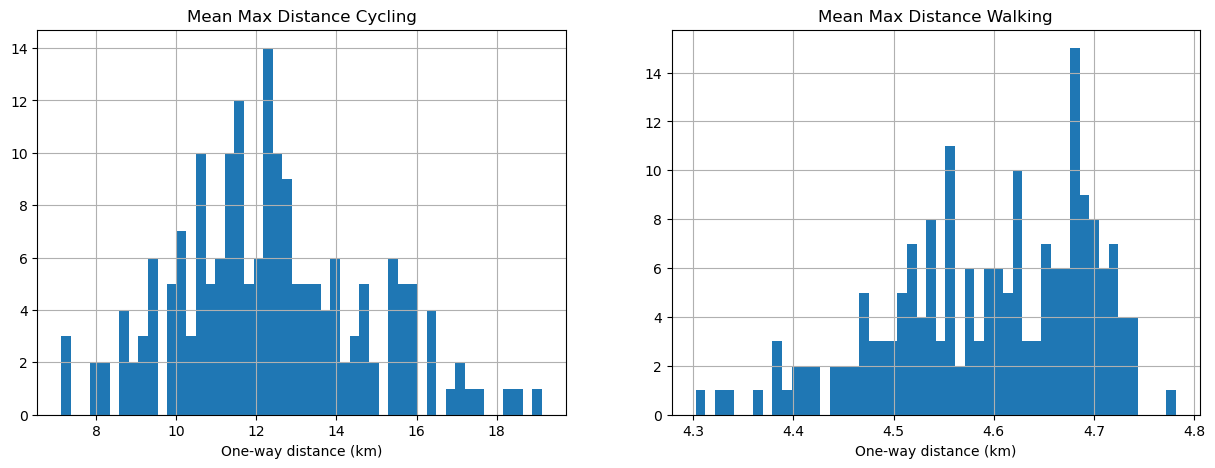

In [22]:
# plot distribution of max distance walking and cycling
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df_countries["mean_max_distance_cycling"].hist(bins=50, ax=ax[0])
ax[0].set_title("Mean Max Distance Cycling")
ax[0].set_xlabel("One-way distance (km)")
df_countries["mean_max_distance_walking"].hist(bins=50, ax=ax[1])
ax[1].set_title("Mean Max Distance Walking")
ax[1].set_xlabel("One-way distance (km)")
plt.show()

#TODO do the above for df_zones to show full distribution of walking and cycling distances


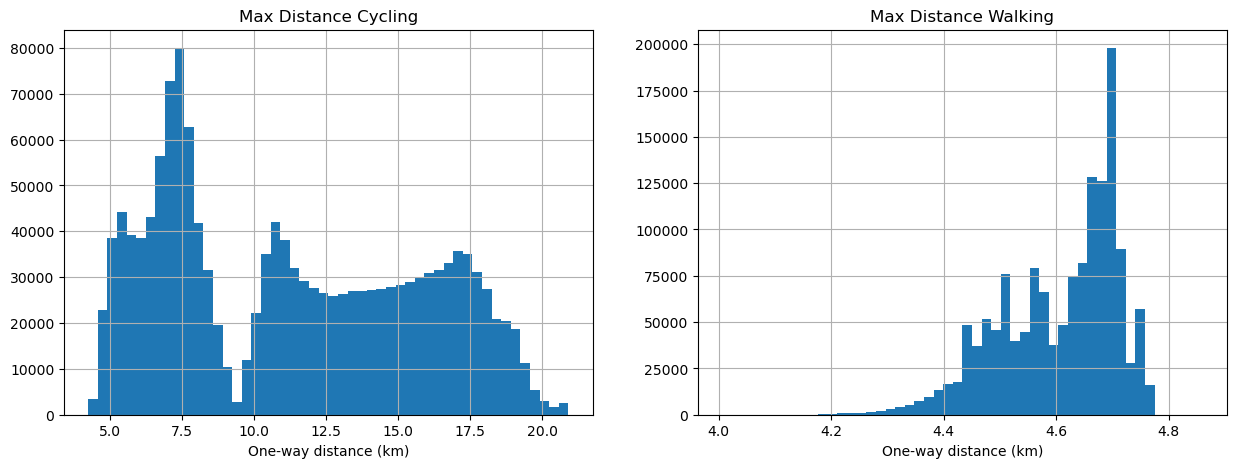

In [23]:
# plot distribution of max distance walking and cycling in df_zones
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df_zones["max distance cycling"].hist(bins=50, ax=ax[0])
ax[0].set_title("Max Distance Cycling")
ax[0].set_xlabel("One-way distance (km)")
df_zones["max distance walking"].hist(bins=50, ax=ax[1])
ax[1].set_title("Max Distance Walking")
ax[1].set_xlabel("One-way distance (km)")
plt.show()


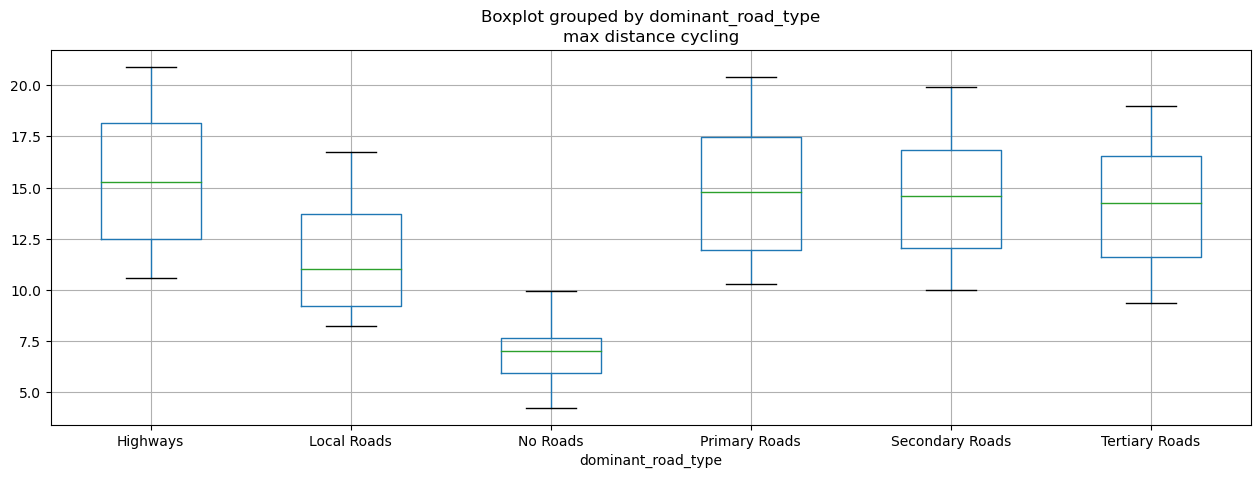

In [24]:
# plot dominant road type vs max distance cycling
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
df_zones.boxplot(column="max distance cycling", by="dominant_road_type", ax=ax)
plt.show()



In [25]:
# order df zones by slope_1, then plot cumulative population counts to see how the population is distributed by slope
df_zones_sorted = df_zones.sort_values("slope_1")
df_zones_sorted["cumulative_pop"] = df_zones_sorted["pop_zone"].cumsum()

# Calculate the 95th percentile
percentile_95 = df_zones['pop_zone'].quantile(0.05)

# Create the plot
ax = df_zones_sorted.plot(x='slope_1', y='cumulative_pop')
plt.xlabel("slope_1")
plt.ylabel("Cumulative Population")
plt.title("Cumulative Population by Zone")

# Add a vertical line at the 95th percentile
plt.axvline(y=percentile_95, color='r', linestyle='--')

# Add text to indicate the 95th percentile
plt.text(0.1, percentile_95, f'95th percentile: {percentile_95}', color='r')

plt.show()

: 

In [23]:
# plot slope vs population with df_zones
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# df_zones.plot.scatter(x="slope_1", y="pop_zone", ax=ax)
# ax.set_xlabel("Slope")
# ax.set_ylabel("Population")
# plt.show()

: 

In [ ]:
# calculate what slope_1 that 90 percenent of pop_zone is below
# slope_90 = df_zones["slope_1"].quantile(0.9)
# print(f"90% of the population is below a slope of {slope_90:.2f}")


In [ ]:
# plot max distance walking for df_zones, colour by country
import plotly.graph_objects as go

fig = go.Figure()

# Add vertical lines for max distance walking
for country, distance in zip(df_zones["Entity"], df_zones["max distance walking"]):
    fig.add_shape(
        type="line",
        x0=distance,
        x1=distance,
        y0=0,
        y1=1,
        line=dict(color=df_zones[df_zones["Entity"]==country]["ISOCODE"].values[0], width=1),
    )

# Update layout
fig.update_layout(
    title="Max Distance Walking",
    xaxis=dict(title=""),
    yaxis=dict(title=""),
    showlegend=False,
)

fig.show()



ValueError: 
    Invalid value of type 'builtins.str' received for the 'color' property of layout.shape.line
        Received value: 'AFG'

    The 'color' property is a color and may be specified as:
      - A hex string (e.g. '#ff0000')
      - An rgb/rgba string (e.g. 'rgb(255,0,0)')
      - An hsl/hsla string (e.g. 'hsl(0,100%,50%)')
      - An hsv/hsva string (e.g. 'hsv(0,100%,100%)')
      - A named CSS color:
            aliceblue, antiquewhite, aqua, aquamarine, azure,
            beige, bisque, black, blanchedalmond, blue,
            blueviolet, brown, burlywood, cadetblue,
            chartreuse, chocolate, coral, cornflowerblue,
            cornsilk, crimson, cyan, darkblue, darkcyan,
            darkgoldenrod, darkgray, darkgrey, darkgreen,
            darkkhaki, darkmagenta, darkolivegreen, darkorange,
            darkorchid, darkred, darksalmon, darkseagreen,
            darkslateblue, darkslategray, darkslategrey,
            darkturquoise, darkviolet, deeppink, deepskyblue,
            dimgray, dimgrey, dodgerblue, firebrick,
            floralwhite, forestgreen, fuchsia, gainsboro,
            ghostwhite, gold, goldenrod, gray, grey, green,
            greenyellow, honeydew, hotpink, indianred, indigo,
            ivory, khaki, lavender, lavenderblush, lawngreen,
            lemonchiffon, lightblue, lightcoral, lightcyan,
            lightgoldenrodyellow, lightgray, lightgrey,
            lightgreen, lightpink, lightsalmon, lightseagreen,
            lightskyblue, lightslategray, lightslategrey,
            lightsteelblue, lightyellow, lime, limegreen,
            linen, magenta, maroon, mediumaquamarine,
            mediumblue, mediumorchid, mediumpurple,
            mediumseagreen, mediumslateblue, mediumspringgreen,
            mediumturquoise, mediumvioletred, midnightblue,
            mintcream, mistyrose, moccasin, navajowhite, navy,
            oldlace, olive, olivedrab, orange, orangered,
            orchid, palegoldenrod, palegreen, paleturquoise,
            palevioletred, papayawhip, peachpuff, peru, pink,
            plum, powderblue, purple, red, rosybrown,
            royalblue, rebeccapurple, saddlebrown, salmon,
            sandybrown, seagreen, seashell, sienna, silver,
            skyblue, slateblue, slategray, slategrey, snow,
            springgreen, steelblue, tan, teal, thistle, tomato,
            turquoise, violet, wheat, white, whitesmoke,
            yellow, yellowgreen

In [ ]:
# sunburst plot of continents then countries, with population without water as values and color
fig = px.sunburst(
    df_countries,
    path=["Entity", "region"],
    values="percent_without_water",
    color="percent_without_water",
    hover_data=hover_data_list,
    title="Population without Water by Country",
)
fig.show()

In [ ]:
import os
map2 = px.choropleth(
    title="Percent of Population Has to Relocate",
    data_frame=df_zones,
    locations="fid",
    height=600,
    color="fraction_of_zone_with_walking_access",
    # use constant colorbar grading (not relative)
    color_continuous_scale="ylorbr",
    range_color=(0, 100),
    scope="world",
    # hover_name="Entity",
    # hover_data=hover_data_list
)
map2.layout.coloraxis.colorbar.title = ''




In [ ]:
# create bubble chart from df_countries comprising: access to water, piped water, and using population as the size of the bubble
# create a new column for the size of the bubble
df_countries["bubble_size"] = df_countries["country_pop_raw"] / 1000000 +50

# create a new column for the color of the bubble
df_countries["bubble_color"] = df_countries["Nat Piped"]

# create a new column for the text of the bubble
df_countries["bubble_text"] = df_countries["Entity"]

px.scatter(df_countries, x="percent_without_water", y="Nat Piped", size="bubble_size", color="region", hover_name="bubble_text", title="Access to Water vs. Piped Water vs. Population")

Above graph is the money shot. NMeed to fix bubble sizes, maybe add labels

In [ ]:
#sort the countries by distance to water, plot the results
df_countries.sort_values(by="weighted_med", inplace=True)
# add log scale
px.line(df_countries, x="Entity", y="weighted_med", color="subregion", title="Distance to Water", log_y=True)


In [ ]:
# plot the countries by population withgout water and percent without water
px.scatter(df_countries, x="percent_without_water", y="country_pop_without_water", size="bubble_size", color="region", hover_name="bubble_text", title="Population vs. Percent Without Water")


In [ ]:
# summary statistics of zones by for slected country
# select country
country = "CAF"

# interertsinbg ciolumns
interesting_cols =[
    "Entity",
    "dtw_1",
    "pop_zone",
    "country_pop_raw",
    "population_piped_with_access",
    "population_piped_with_cycling_access",
    "population_piped_with_walking_access",
    "Nat Piped",
    "region",
]

other_cols = [
    "zone_pop_unpiped",
    "zone_pop_piped",
    "pop_zone"

]

# create dataframe of zones for selected country
df_zones_country = df_zones[df_zones["ISOCODE"] == country]
df_zones_country = df_zones_country[other_cols]

# create summary statistics
df_zones_country.describe()







,zone_pop_unpiped,zone_pop_piped,pop_zone
count,6989.000000,6989.000000,6989.000000
mean,333.000173,14.005927,703.704579
std,1584.341692,637.787037,3228.167566
min,4.921786,0.000000,10.471884
25%,52.380365,0.000000,111.447585
50%,137.371647,0.000000,292.280099
75%,375.727821,0.000000,799.420895
max,51604.171664,30764.025415,99238.791662


In [ ]:
# create stacked bar chart, stacking  "country_pop_with_water", and "country_pop_without_water" on the y axis as two bars. Using region as the x axis.
# px.bar(df_countries, x="region", y=["country_pop_with_water", "country_pop_without_water"], title="Population with Water vs. Population without Water", hover_data=["Entity"])

# create the same, but put the bars side by side
px.bar(df_countries, x="region", y=["country_pop_with_water", "country_pop_without_water"], barmode="group", title="Population with Water vs. Population without Water", hover_data=["Entity"])






In [ ]:
# df_countries.to_csv(export_file_location + "country_data_chloro.csv")